As mentioned in the paper this baseline model has considered from the `BERT-Attention` model from the paper [Utilizing BERT Intermediate Layers for Aspect Based Sentiment Analysis and Natural Language Inference](https://aclanthology.org/N19-1035/). We have considered taking code from the paper where the authors has released the code opensource in [GitHub](https://github.com/avinashsai/BERT-Aspect). To run this code there are addtional files required to load the models which we have already shared in the Baseline directory.

In [1]:

## Loading all the required libraries
import pandas as pd
import copy
import numpy as np
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F
from model import Bert_Base, Bert_Attention, Bert_LSTM
from tqdm import tqdm
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import matplotlib.pyplot as plt

In [3]:
## As we are running in GPU. So we are initializing for the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [5]:
## Loading the dataset and splitting the test dataset for later
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[:1803].reset_index( drop = True)

In [7]:
## As we doing predicting modelling by predicting rating of the each movie. So setting the numclasses to 1
numclasses = 1
model = Bert_Attention(numclasses, device).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                                   do_lower_case=True
                                                   )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT Model Loaded


In [9]:
## Customized dataset loader class for loading the dataset
class SubtitlesDataset(Dataset):
    def __init__(self, texts, labels_regression, tokenizer, max_length):
        self.texts = texts
        self.labels_regression = labels_regression
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label_regression = float(self.labels_regression[idx])

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        #print("encoding :", encoding)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        token_type_ids = encoding['token_type_ids'].squeeze()

        return input_ids, attention_mask, token_type_ids, label_regression

In [11]:
## In this code cell we are splitting the train and validation datasets
texts = df['subtitles'].tolist()
labels_regression = df['Language'].tolist()
train_texts, val_texts, train_labels_regression, val_labels_regression = train_test_split(texts, 
                                                                                          labels_regression, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

In [12]:
## By utilizing the dataloader class above we are creating train and validation dataloaders
train_dataset = SubtitlesDataset(train_texts, train_labels_regression, tokenizer, max_length=128)
val_dataset = SubtitlesDataset(val_texts, val_labels_regression, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [32]:

## Initializing the hyperparameters and lists for storing train and validation losses

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-05)
num_epochs = 25
train_losses = []
val_losses = []


for epoch in tqdm(range(num_epochs)):
    ## Training MODE
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_id, attention_masks, token_ids, labels = batch
        input_id = input_id.to(device)
        attention_masks = attention_masks.to(device)
        token_ids = token_ids.to(device)
        labels = labels.long().to(device)
        regression_output = model(input_id, attention_masks, token_ids)
        labels_regression = labels.float()
        regression_output = regression_output.squeeze(-1)
        loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    ## Evaluation Mode
    model.eval()
    total_val_loss = 0


    with torch.no_grad():
        for batch in val_loader:
            input_id, attention_masks, token_ids, labels = batch
            input_id = input_id.to(device)
            attention_masks = attention_masks.to(device)
            token_ids = token_ids.to(device)
            labels = labels.long().to(device)
            
            regression_output = model(input_id, attention_masks, token_ids)
            labels_regression = labels.float()
            regression_output = regression_output.squeeze(-1)
            val_loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    ## Printing Training and Validation
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

  4%|████▊                                                                                                                    | 1/25 [03:27<1:23:07, 207.80s/it]

Epoch 1/25, Training Loss: 13.9415, Validation Loss: 8.5120


  8%|█████████▋                                                                                                               | 2/25 [06:54<1:19:24, 207.16s/it]

Epoch 2/25, Training Loss: 11.6125, Validation Loss: 6.9845


 12%|██████████████▌                                                                                                          | 3/25 [10:21<1:15:54, 207.02s/it]

Epoch 3/25, Training Loss: 10.9074, Validation Loss: 10.0282


 16%|███████████████████▎                                                                                                     | 4/25 [13:40<1:11:25, 204.07s/it]

Epoch 4/25, Training Loss: 8.5924, Validation Loss: 9.0295


 20%|████████████████████████▏                                                                                                | 5/25 [16:52<1:06:30, 199.54s/it]

Epoch 5/25, Training Loss: 9.2021, Validation Loss: 6.9236


 24%|█████████████████████████████                                                                                            | 6/25 [20:02<1:02:12, 196.43s/it]

Epoch 6/25, Training Loss: 8.3710, Validation Loss: 7.1455


 28%|██████████████████████████████████▍                                                                                        | 7/25 [23:13<58:24, 194.68s/it]

Epoch 7/25, Training Loss: 9.0254, Validation Loss: 8.3607


 32%|███████████████████████████████████████▎                                                                                   | 8/25 [26:24<54:48, 193.42s/it]

Epoch 8/25, Training Loss: 8.7874, Validation Loss: 10.7403


 36%|████████████████████████████████████████████▎                                                                              | 9/25 [29:35<51:22, 192.63s/it]

Epoch 9/25, Training Loss: 8.6519, Validation Loss: 7.0924


 40%|████████████████████████████████████████████████▊                                                                         | 10/25 [32:45<47:59, 191.97s/it]

Epoch 10/25, Training Loss: 8.3217, Validation Loss: 7.5606


 44%|█████████████████████████████████████████████████████▋                                                                    | 11/25 [35:56<44:43, 191.67s/it]

Epoch 11/25, Training Loss: 7.3841, Validation Loss: 7.4266


 48%|██████████████████████████████████████████████████████████▌                                                               | 12/25 [39:08<41:29, 191.53s/it]

Epoch 12/25, Training Loss: 7.7194, Validation Loss: 6.9984


 52%|███████████████████████████████████████████████████████████████▍                                                          | 13/25 [42:18<38:14, 191.21s/it]

Epoch 13/25, Training Loss: 7.3190, Validation Loss: 7.7917


 56%|████████████████████████████████████████████████████████████████████▎                                                     | 14/25 [45:29<35:02, 191.13s/it]

Epoch 14/25, Training Loss: 7.4619, Validation Loss: 6.3275


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 15/25 [48:40<31:49, 190.97s/it]

Epoch 15/25, Training Loss: 7.9558, Validation Loss: 8.7858


 64%|██████████████████████████████████████████████████████████████████████████████                                            | 16/25 [51:50<28:37, 190.87s/it]

Epoch 16/25, Training Loss: 6.9384, Validation Loss: 6.6743


 68%|██████████████████████████████████████████████████████████████████████████████████▉                                       | 17/25 [55:02<25:27, 190.96s/it]

Epoch 17/25, Training Loss: 9.0630, Validation Loss: 10.0682


 72%|███████████████████████████████████████████████████████████████████████████████████████▊                                  | 18/25 [58:12<22:16, 190.92s/it]

Epoch 18/25, Training Loss: 6.5080, Validation Loss: 7.1572


 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 19/25 [1:01:23<19:04, 190.82s/it]

Epoch 19/25, Training Loss: 10.1637, Validation Loss: 11.2617


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 20/25 [1:04:34<15:54, 190.88s/it]

Epoch 20/25, Training Loss: 7.6396, Validation Loss: 5.8946


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 21/25 [1:07:44<12:43, 190.76s/it]

Epoch 21/25, Training Loss: 6.4933, Validation Loss: 8.9885


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 22/25 [1:10:55<09:32, 190.77s/it]

Epoch 22/25, Training Loss: 9.1066, Validation Loss: 9.2126


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 23/25 [1:14:06<06:21, 190.83s/it]

Epoch 23/25, Training Loss: 7.0477, Validation Loss: 5.9598


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 24/25 [1:17:18<03:11, 191.02s/it]

Epoch 24/25, Training Loss: 6.0150, Validation Loss: 7.0325


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [1:20:29<00:00, 193.20s/it]

Epoch 25/25, Training Loss: 5.9938, Validation Loss: 6.2228


In [ ]:
# Time took to run this code 1:20:29

In [35]:

## Storing the Loss values in dictionary for creating and storing the results in the dataframe
data = {'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses}

df2 = pd.DataFrame(data)
excel_filename = "losses_per_epoch2_bart_attention.xlsx"
df2.to_excel(excel_filename, index=False)
print("Train and Validation Losses per Epoch saved to:", excel_filename)

Train and Validation Losses per Epoch saved to: losses_per_epoch2_bart_attention.xlsx


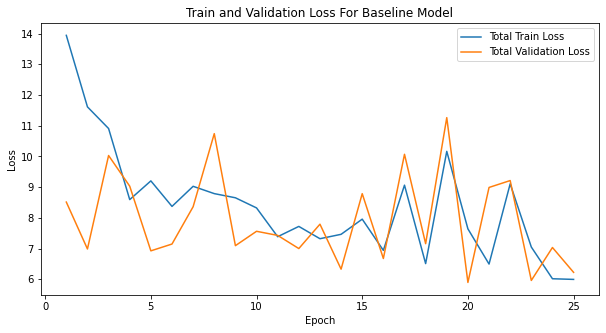

In [38]:
## Plotting the Loss values
df_excel= pd.read_excel("./losses_per_epoch2_bart_attention.xlsx")
plt.figure(figsize = (10, 5))
plt.plot(range(1, 26), df_excel['Train Loss'].tolist(), label='Total Train Loss')
plt.plot(range(1, 26), df_excel['Validation Loss'].tolist(), label='Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss For Baseline Model')
plt.legend()

plt.savefig("baseline_model_losses.pdf")
plt.show()

In [39]:
## Minimum Validataion loss
min(val_losses)

5.894572099049886

In [ ]:
## Storing and Loading the model for future doing inference
# torch.save(model.state_dict(), 'models/baseline_bart_attention(baseline1).pth')
# model = Bert_Attention(numclasses, device).to(device)
# model.load_state_dict(torch.load('models/baseline_bart_attention(baseline1).pth'))

In [ ]:

## Now doing inference on the test dataset

df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[1803:].reset_index( drop = True)

model.eval()
predictions=[]
for sub in tqdm(df.subtitles):
    
    inputs = tokenizer(sub, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    
    # Get input_ids and attention_mask from the tokenizer output
    input_id = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_ids = inputs['token_type_ids'].to(device)
    
    model.eval()
    with torch.no_grad():
        regression_output = model(input_id, attention_mask, token_ids).squeeze(-1)
    
    predicted_score = regression_output.item()

    predictions.append(predicted_score)


In [114]:
## Evaluating the performance of the model and printing the r

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
df_predictions = pd.DataFrame({ 'Language_Score':df['Language'].tolist(),"Predcited_Score":predictions})
true_labels = np.array(df_predictions['Language_Score'].tolist())
predicted_scores=np.array(df_predictions['Predcited_Score'].tolist())
mse = mean_squared_error(true_labels, predicted_scores)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predicted_scores)
r2 = r2_score(true_labels, predicted_scores)
evs = explained_variance_score(true_labels, predicted_scores)

print("mse: ",mse)
print("rmse: ",rmse)
print("mae: ",mae)
print("r2: ",r2)
print("evs: ",evs)
